# Feed-forward Artificial Neural Networks

In [143]:
import numpy as np
import jax.numpy as jnp
import jax
import matplotlib.pyplot as plt
import time
import copy

## Learning the XOR function

Let us consider the XOR ("exclusive or") function. The [truth table](https://en.wikipedia.org/wiki/Exclusive_or#Truth_table) of the XOR function is:

In [2]:
inputs = np.array([[0, 0], 
                   [0, 1], 
                   [1, 0], 
                   [1, 1]])
outputs = np.array([[0], 
                    [1], 
                    [1], 
                    [0]])

We consider a fully connected ANN with the following architechture and with $\tanh(\cdot)$ as activation function:

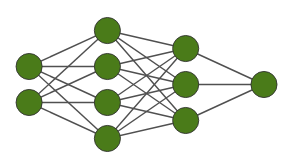

The input of the network are the truth values of the two inputs (0 = False, 1 = True). The output is the **likelihood** (the "probability") of the truth value of the result. Hence, we want the output to be in $[0, 1]$. For this reason, we apply the activation function also to the last layer, and we rescale the output between 0 and 1.


The architecture is defined by the following **hyperparameters**:

In [3]:
n1, n2, n3, n4 = 2, 4, 3, 1

Define the parameters (weights and biases) of the ANN. 
Initialize the weights sampling from a standard normal distribution, and initialize to zero the biases.

Define both the weights and the biases as a 2-dimensional `numpy` array.

In [132]:
np.random.seed(0) # for reproducibility

W1 = np.random.randn(n2, n1)
b1 = np.zeros((n2, 1))
W2 = np.random.randn(n3, n2)
b2 = np.zeros((n3, 1))
W3 = np.random.randn(n4, n3)
b3 = np.zeros((n4, 1))

parameters = [[W1, b1], [W2, b2], [W3, b3]]


In [133]:
inputs, W1, b1

(array([[0, 0],
        [0, 1],
        [1, 0],
        [1, 1]]),
 array([[ 1.76405235,  0.40015721],
        [ 0.97873798,  2.2408932 ],
        [ 1.86755799, -0.97727788],
        [ 0.95008842, -0.15135721]]),
 array([[0.],
        [0.],
        [0.],
        [0.]]))

Define a function that implements the ANN:
```python
def ANN(x, params):
  ...
```
with inputs:
- `x`: num_samples by 2 `numpy` array
- `params`: list of the parameters
and with output
- `y`: num_samples by 1 `numpy` array

Then, test the function on `inputs` and `params`.

In [114]:
def ANN(x, params):
    x = x.T
    for (W, b) in params:
        x = jnp.tanh(W @ x + b)
    return ((x + 1) / 2).T

In [115]:
y_pred = ANN(inputs, parameters)

#y_pred = np.round(y_pred)

accuracy = len(np.where(y_pred == outputs)) / 4
y_pred, accuracy

(Array([[0.5       ],
        [0.57224154],
        [0.107804  ],
        [0.10987768]], dtype=float32),
 0.5)

Print the truth table associated with the ANN.

In [116]:
for a in (0,1):
  for b in (0,1):
    out = ANN(np.array([[a,b]]), parameters)[0]
    print('%d XOR %d --> %f' % (a, b, out))

0 XOR 0 --> 0.500000
0 XOR 1 --> 0.572242
1 XOR 0 --> 0.107804
1 XOR 1 --> 0.109878


C:\Users\nrtc\AppData\Local\Temp\ipykernel_28232\2133248182.py:4: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future.
  print('%d XOR %d --> %f' % (a, b, out))


Define a function that computes the quadratic loss on a set of data:
```python
def loss_quadratic(x, y, params):
  ...
```
with inputs:
- `x`: num_samples by 2 `numpy` array
- `y`: num_samples by 1 `numpy` array
- `params`: list of the parameters
and with output
- `loss`: scalar

Then, test the function on `inputs`, `outputs` and `params`.

In [78]:
def loss_quadratic(x, y, params):
    out = ANN(x, params)
    return ((1 / len(out[0])) * jnp.sum(jnp.power((y - out), 2)))

In [117]:
loss_quadratic(inputs, outputs, parameters)

Array(1.2410641, dtype=float32)

Define a function that computes the cross-entropy loss on a set of data:
```python
def loss_crossentropy(x, y, params):
  ...
```
with inputs:
- `x`: num_samples by 2 `numpy` array
- `y`: num_samples by 1 `numpy` array
- `params`: list of the parameters
and with output
- `loss`: scalar

Then, test the function on `inputs`, `outputs` and `params`.

In [80]:
def loss_crossentropy(x, y, param):
    out = ANN(x, params)
    return jnp.sum(-(y*jnp.log(out) + (1-y)*jnp.log(1-out)))

In [118]:
loss_crossentropy(inputs, outputs, parameters)

Array(3.5951784, dtype=float32)

Using the JIT module of JAX, compile both the losses defined above and their gradients w.r.t. the parameters.

In [82]:
sse_jit = jax.jit(loss_quadratic)
bce_jit = jax.jit(loss_crossentropy)

sse_grad = jax.jit(jax.grad(sse_jit, argnums = 2))
bce_grad = jax.jit(jax.grad(bce_jit, argnums = 2))

Implement the GD (gradient descent) method, with learning rate 0.1 and train the ANN, using either the quadratic or the cross-entropy loss function.
Collect the training history of both loss functions at each training epoch and plot them. 

Finally, print the truth table associated with the ANN and compute its accuracy.

In [149]:
loss_fn = sse_jit
loss_grad_fn = sse_grad
threshold = 0.01
lr = 0.1
epochs = 2000

In [153]:
def train(x, y, p, loss_fn, loss_grad_fn):
    t0 = time.time()
    history_loss = []

    for _ in range(epochs):
        grad = loss_grad_fn(x, y, p)
        for i, (W, b) in enumerate(p):
            p[i][0] = W - lr * grad[i][0]
            p[i][1] = b - lr * grad[i][1]
        history_loss.append(loss_fn(x, y, p))

    return p, history_loss, time.time() - t0

def train_sse(x, y, p):
    return train(x, y, p, sse_jit, sse_grad)

def train_bce(x, y, p):
    return train(x,y,p,bce_jit,bce_grad)

In [154]:
new_params_sse, history_loss_sse, time_sse = train_sse(inputs, outputs, copy.deepcopy(parameters))
new_params_bce, history_loss_bce, time_bce = train_bce(inputs, outputs, copy.deepcopy(parameters))

print(f"SSE:{time_sse:2e}s, BCE:{time_bce:2e}s")

SSE:4.433832e-01s, BCE:4.235604e-01s


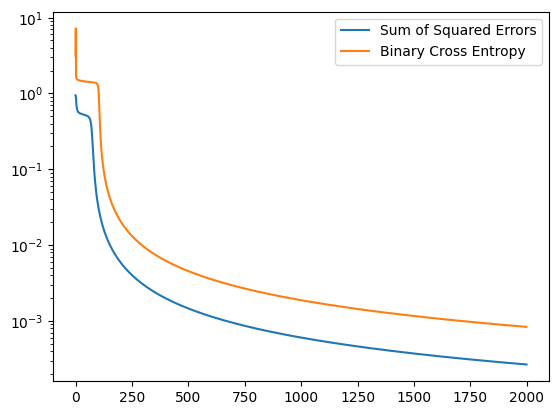

In [155]:
plt.semilogy(history_loss_sse, label="Sum of Squared Errors")
plt.semilogy(history_loss_bce, label="Binary Cross Entropy")
plt.legend()

In [156]:
for a in (0,1):
  for b in (0,1):
    out_sse = ANN(np.array([[a,b]]), new_params_sse)[0]
    out_bce = ANN(np.array([[a,b]]), new_params_bce)[0]
    print('%d XOR %d --> SSE:%f, BCE:%f' % (a, b, out_sse, out_bce))

0 XOR 0 --> SSE:0.004794, BCE:0.000080
0 XOR 1 --> SSE:0.993524, BCE:0.999850
1 XOR 0 --> SSE:0.988720, BCE:0.999621
1 XOR 1 --> SSE:0.008618, BCE:0.000226


C:\Users\nrtc\AppData\Local\Temp\ipykernel_28232\3296591437.py:5: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future.
  print('%d XOR %d --> SSE:%f, BCE:%f' % (a, b, out_sse, out_bce))


In [157]:
pred_sse = np.round(ANN(inputs, new_params_sse))
pred_bce = np.round(ANN(inputs, new_params_bce))

accuracy_sse = np.sum(outputs == pred_sse)/len(outputs)
accuracy_bce = np.sum(outputs == pred_bce)/len(outputs)

print(f"SSE Accuracy: {accuracy_sse * 100}%, BCE Accuracy: {accuracy_bce * 100}%")

SSE Accuracy: 100.0%, BCE Accuracy: 100.0%
